# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Загрузка данных

In [2]:
try:
    df = pd.read_csv('H:/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
old_shape = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Использовав метод `info` можем увидеть что названия столбцов имеют не корректный вид. Поэтому приведём все названия столбцов к нижнему регистру и разделим слова чертами

Также можно отметить что все столбцы имеют корректный тип данных 

In [5]:
df.columns = map(str.lower, df.columns)

In [6]:
df.rename({'datecrawled': 'date_crawled',
           'vehicletype': 'vehicle_type',
           'registrationyear': 'registration_year',
           'gearbox': 'gear_box',
           'regisrationmonth': 'registration_month',
           'fueltype': 'fuel_type',
           'numberofpictures': 'number_of_pictures',
           'postalcode': 'postal_code',
           'lastseen': 'last_seen',
           'datecreated': 'date_created',
           'registrationmonth': 'registration_month'
           }, axis=1, inplace=True)

Найдём количество пропусков в столбцах. Пропуски имеют только категориальные столбцы.

In [7]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gear_box              19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

# Исследовательский анализ даных

Построим матрицу корреляций для количественных признаков.

In [8]:
px.imshow(df.corr().drop('number_of_pictures', axis=1).
                    drop('number_of_pictures', axis=0),text_auto=True)

Исходя из матрицы корреляции можно увидеть , что ни один из количественных признаков не имеет сильной зависимости от какого-либо другого признака.

Построим гистограммы для количественных признаков, чтобы посмотреть на их распределения

In [9]:
def histg(column_name):
    fig = go.Figure()

    fig.add_trace(
        go.Histogram(x=df[column_name], autobinx=True, opacity=.8)
    )
    fig.update_layout(
        title={
            'text': column_name,
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()

In [10]:
for name in ['price','registration_year','power','kilometer','registration_month','number_of_pictures']:
    histg(name)

Анализируя графики видно, что:
 - `price` - Имеет большое количество выбросов до 400 евро, такая цена машины совсем не реалистична для современного мира.\
 - `registration_year` - Имеет небольшое кол-во выбросов вне промежутка (1975 - 2020 г.)\
 Медианное значение года регистрации - 2004 г.
 - `power` - Имеет большое количество выбросов мощностью до 30 л.с или более 1200 л.с, что также не реалистично относительно современных машин.
 - `kilometer` - Имеет наибольшее кол-во объявлений для машин чей пробег ~ 150000 км.
 - `registration month` - Стремится к константному распределению
 - `number_of_pictures` - Ни в одном из объявлений нет фотографий, поэтому данный признак будет не информативен для дальнейшего использования

# Предобработка данных

Заменим аномальные значения в столбцах `power`, `registration_year`,`price`:
 - `power` - Замена с помощью медианного значения промежутка (30-1200 л.с)
 - `registration_year` - Замена с помощью медианного значения всего столбца
 - `price` - Так как цена является целевым признаком, то для точности анализа избавимся от строк содержащих аномальную цену

In [11]:
power_medi = df.loc[(df.power > 30) & (df.power < 1200), 'power'].median()

df['power'] = np.where(
    (df['power'] >= 1200) | (df['power'] < 30), power_medi, df['power']
)

In [12]:
year_medi = df['registration_year'].median()

df['registration_year'] = np.where(
    (df['registration_year'] >= 2016) | (
        df['registration_year'] < 1975), year_medi, df['registration_year']
)

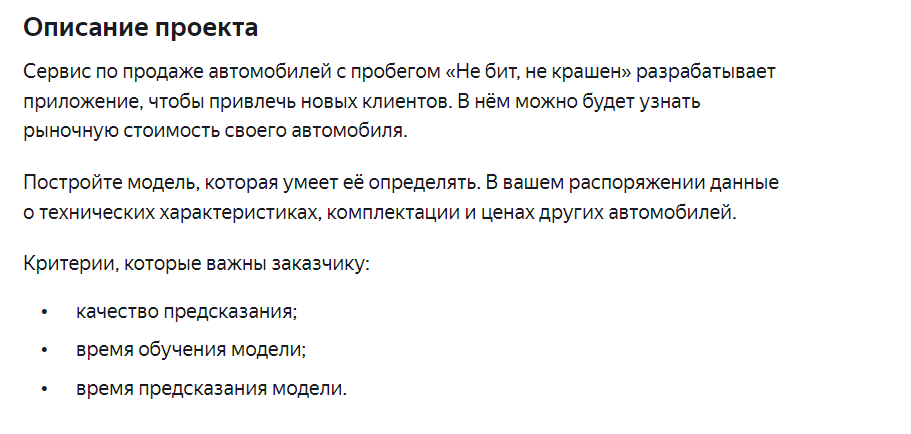

In [13]:
df.drop(index=df[df.price <= 400].index, inplace=True, axis=0)

Посмотрим на распределение категориальных признаков в которых есть пропуски:

In [14]:
cat_list = ['vehicle_type', 'gear_box',
                    'model', 'fuel_type', 'repaired','brand']
# for name in cat_list:
#     fig = px.bar(y=df[name].value_counts(), x=df[name].value_counts(
#     ).index, text_auto=True, opacity=.8, labels={'x': name, 'y': 'Количество'})
#     fig.show()

Для того, чтобы избежать удаления данных значений и искажения их исходных распределений - заполним пропуски случайными значениями из своего столбца соответственно.

In [15]:
df.fillna('unknown',inplace=True)

Создадим копию датасета для работы моделей с категориальными признаками, а также "дропнем" неинформативные столбцы

In [16]:
df_cat = df.copy()
df_cat.loc[:,cat_list] = df_cat[cat_list].astype('category')
df_cat.drop(['postal_code', 'date_crawled', 'date_created', 'last_seen',
             'number_of_pictures'], axis=1, inplace=True)

In [17]:
df.reset_index(drop='first',inplace=True)
df.drop(['postal_code', 'date_crawled',
        'number_of_pictures'], axis=1, inplace=True)

Приведём столбцы с датами к типу данных `datetime`

In [18]:
df[['date_created', 'last_seen']] = df[[
    'date_created', 'last_seen']].apply(pd.to_datetime)

Создадим функцию которая будет кластеризировать столбец с датами на 3 группы (LabelEncode):
 - `0` - Поздняя дата
 - `1` - Недавняя дата
 - `2` - Свежая дата

In [19]:
def LabelEncodeDateIndex(df, column_name):
    late_index = df[column_name].sort_values(
    )[:round(len(df[column_name])/3)].index
    middle_index = df[column_name].sort_values()[round(
        len(df[column_name])/3):round(len(df[column_name])*2/3)].index
    early_index = df[column_name].sort_values()[round(
        len(df[column_name])*2/3):round(len(df[column_name]))].index

    df.loc[late_index, column_name] = 0
    df.loc[middle_index, column_name] = 1
    df.loc[early_index, column_name] = 2
    df[column_name] = df[column_name].astype(int)

In [20]:
LabelEncodeDateIndex(df, 'date_created')
LabelEncodeDateIndex(df, 'last_seen')

В итоге после предобработки потеряли чуть больше 9% данных что не должно существенно сказаться на предсказании

In [21]:
(1-df.shape[0]/old_shape[0])*100

9.16022564050467

#  Модели машинного обучения

Разделим выборки на тренировочную и тестовую, на признаки и целевые признаки

In [22]:
features = df.drop('price', axis=1).reset_index(drop='first')
target = df.price.reset_index(drop='first')

train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=.25, random_state=42)

In [23]:
features_cat = df_cat.drop('price', axis=1).reset_index(drop='first')
target_cat = df_cat.price.reset_index(drop='first')

train_features_cat, test_features_cat, train_target_cat, test_target_cat = train_test_split(
    features_cat, target_cat, test_size=.25, random_state=42)

In [24]:
enc = OneHotEncoder(sparse=False,drop='first')
enc.fit(train_features[cat_list])
enc_train_features = enc.transform(train_features[cat_list])
enc_test_features = enc.transform(test_features[cat_list])

In [25]:
train_features.reset_index(drop='first',inplace=True)
train_features = train_features.join(pd.DataFrame(
    enc_train_features, columns=enc.get_feature_names())).drop(cat_list, axis=1)

test_features.reset_index(drop='first',inplace=True)
test_features = test_features.join(pd.DataFrame(
    enc_test_features, columns=enc.get_feature_names())).drop(cat_list, axis=1)

In [30]:
print(
    f'Количество строк тренировочной выборки: {train_features.shape[0]}:{train_target.shape[0]}')
print(
    f'Количество строк тестовой выборки: {test_features.shape[0]}:{test_target.shape[0]}')

Количество строк тренировочной выборки: 241431:241431
Количество строк тестовой выборки: 80477:80477


Создадим функцию, которая будет обучать модель на CV,добиваясь наилучшего score на метрике RMSE, а также строить график `feature importance`, чтобы отслеживать какая из "фичей" влияет больше всего на метрику.



In [31]:
def teach_model(model, parameters, features, target,time_list):
    grid = GridSearchCV(model, parameters, n_jobs=-1,
                        scoring='neg_root_mean_squared_error')
    grid.fit(features, target)
    print(-grid.best_score_)
    print(grid.best_params_)

    try:
        feature_importance = grid.best_estimator_.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        fig = plt.figure(figsize=(12, 50))
        plt.barh(range(len(sorted_idx)),
                 feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(
            features.columns)[sorted_idx])
        plt.title('Feature Importance')
        fig.show()
    except:
        pass
    
    time_list.append([grid.cv_results_['mean_fit_time'][0],grid.cv_results_['mean_score_time'][0],-grid.best_score_])

    return grid.best_estimator_

In [32]:
time_list = []

2348.0168729780466
{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: total: 4.7 s
Wall time: 56.3 s


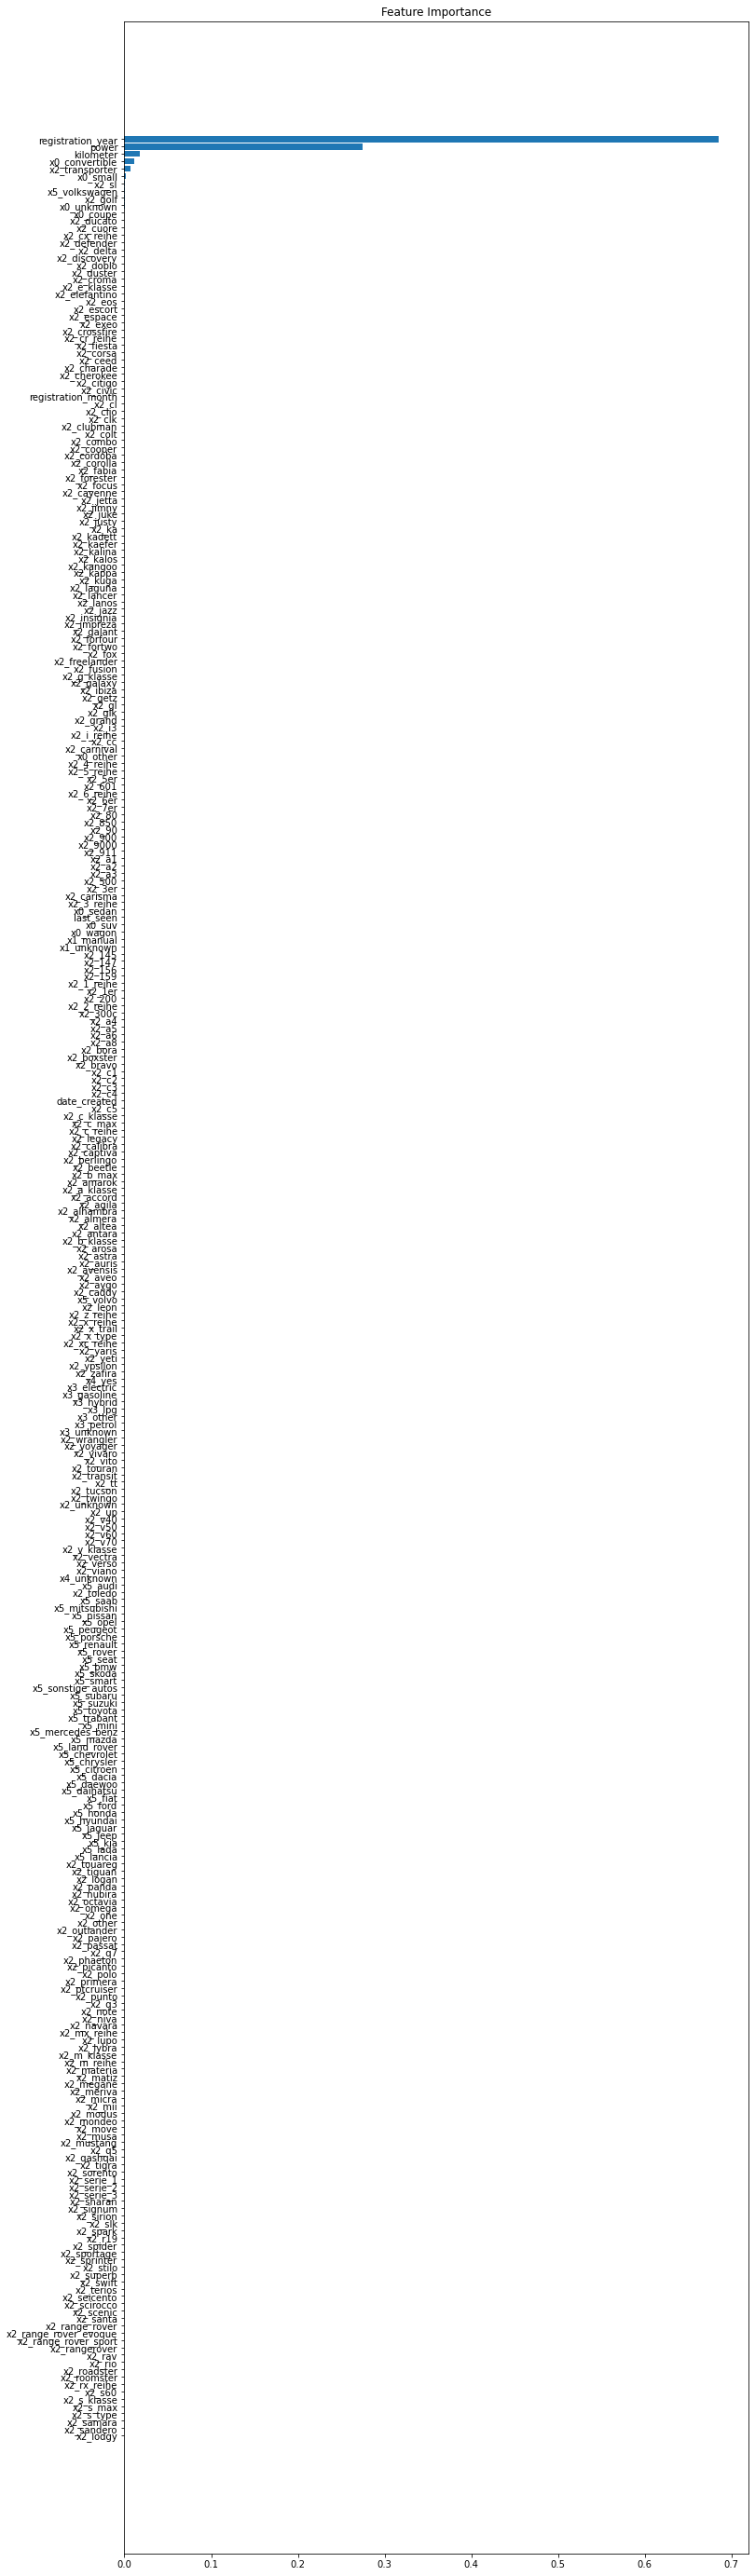

In [33]:
%%time
model = DecisionTreeRegressor(random_state=42)
parameters = {'max_depth': range(2, 7, 1), 'min_samples_split': [
    2, 3], 'min_samples_leaf': [1, 2]}
best_dt = teach_model(model, parameters, train_features, train_target,time_list)

In [34]:
# %%time
# model = CatBoostRegressor(task_type='CPU', random_state=42,cat_features=cat_list)
# parameters = {'iterations': range(
#     100, 1001, 100), 'learning_rate': [.1, .5, .8]}
# best_cb = teach_model(model, parameters, train_features_cat, train_target_cat)

0:	learn: 3199.8758832	total: 160ms	remaining: 2m 40s
1:	learn: 2648.2602500	total: 172ms	remaining: 1m 26s
2:	learn: 2402.8487999	total: 181ms	remaining: 1m
3:	learn: 2280.3375020	total: 192ms	remaining: 47.8s
4:	learn: 2204.6612854	total: 202ms	remaining: 40.2s
5:	learn: 2150.4016570	total: 212ms	remaining: 35.2s
6:	learn: 2110.1471902	total: 223ms	remaining: 31.6s
7:	learn: 2079.1601376	total: 233ms	remaining: 28.8s
8:	learn: 2051.3967738	total: 244ms	remaining: 26.9s
9:	learn: 2028.9030984	total: 254ms	remaining: 25.2s
10:	learn: 2014.0219665	total: 265ms	remaining: 23.8s
11:	learn: 1999.2619717	total: 277ms	remaining: 22.8s
12:	learn: 1988.2561583	total: 287ms	remaining: 21.8s
13:	learn: 1978.2522138	total: 298ms	remaining: 21s
14:	learn: 1962.3523756	total: 308ms	remaining: 20.2s
15:	learn: 1949.5965874	total: 319ms	remaining: 19.6s
16:	learn: 1942.9225312	total: 330ms	remaining: 19.1s
17:	learn: 1930.8531504	total: 342ms	remaining: 18.7s
18:	learn: 1924.9326712	total: 352ms	rema

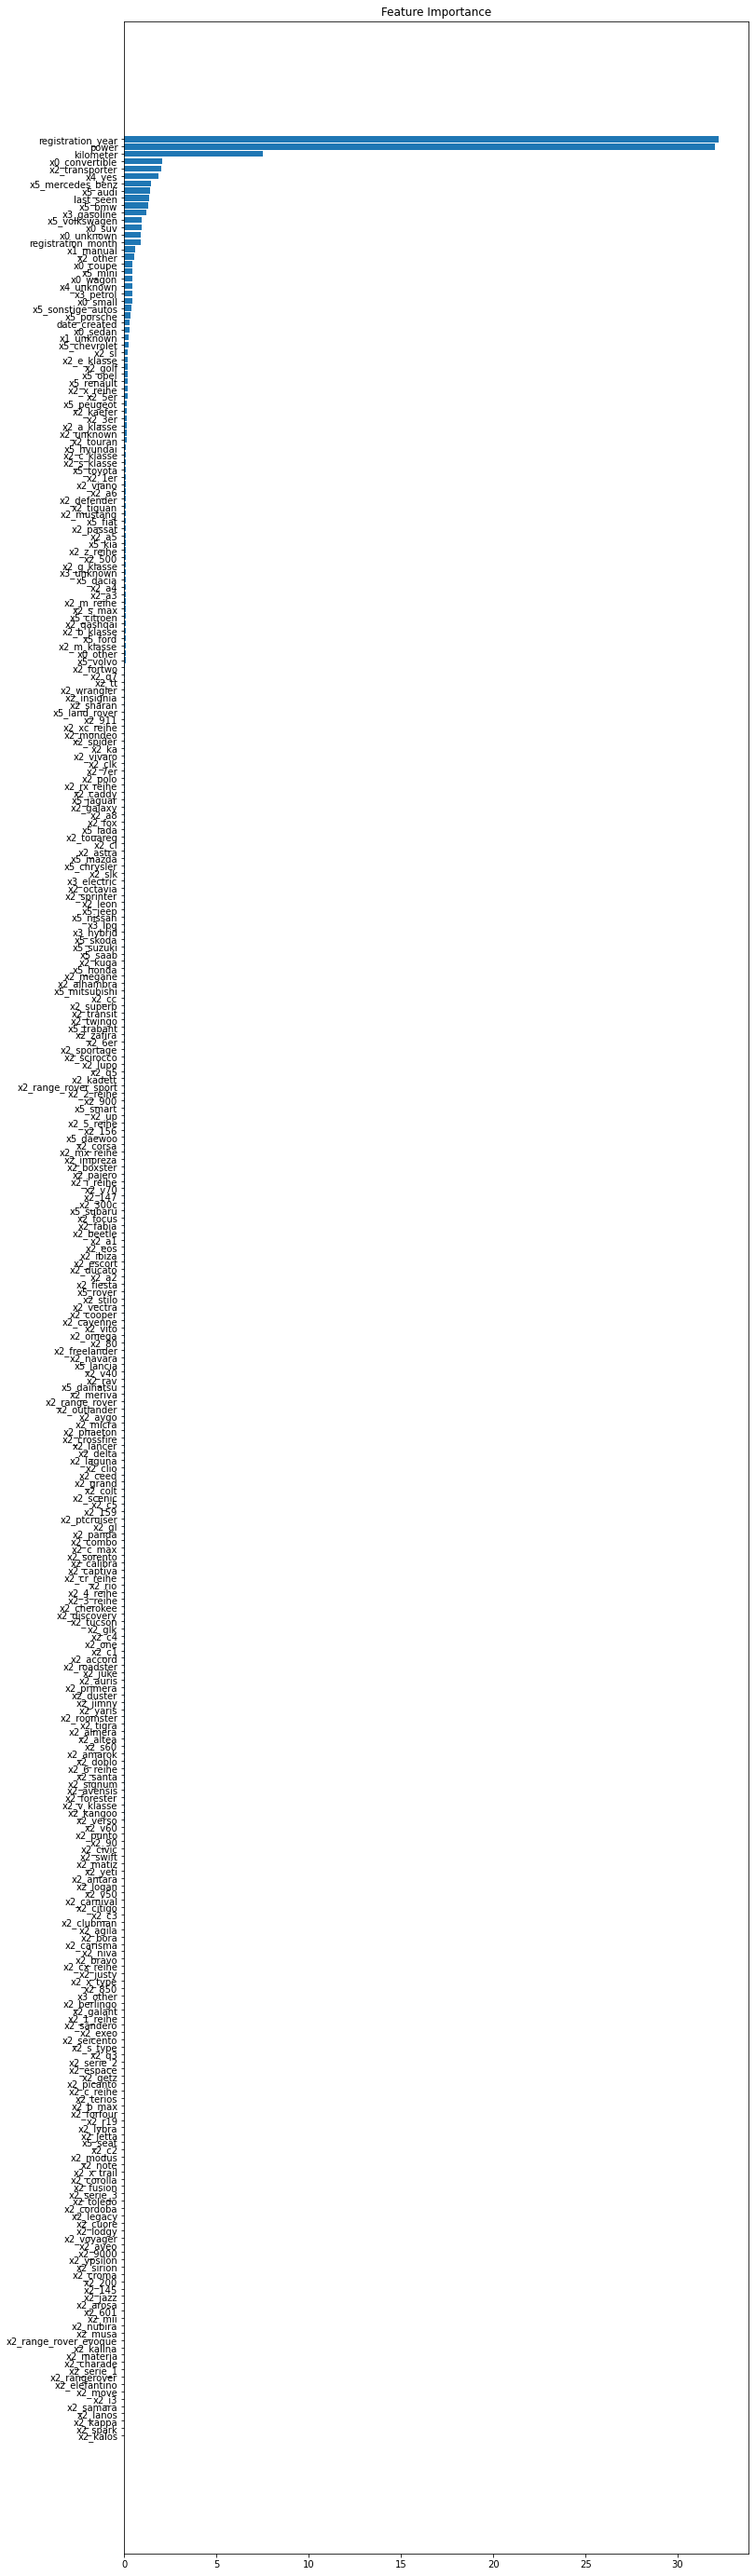

In [35]:
%%time
model = CatBoostRegressor(task_type='CPU', random_state=42)
parameters = {'iterations': range(
    100, 1001, 100), 'learning_rate': [.1, .5, .8]}
best_cb = teach_model(model, parameters, train_features, train_target,time_list)

1630.4270808784722
{'learning_rate': 0.5, 'n_estimators': 300}
CPU times: total: 13min 2s
Wall time: 8min 53s


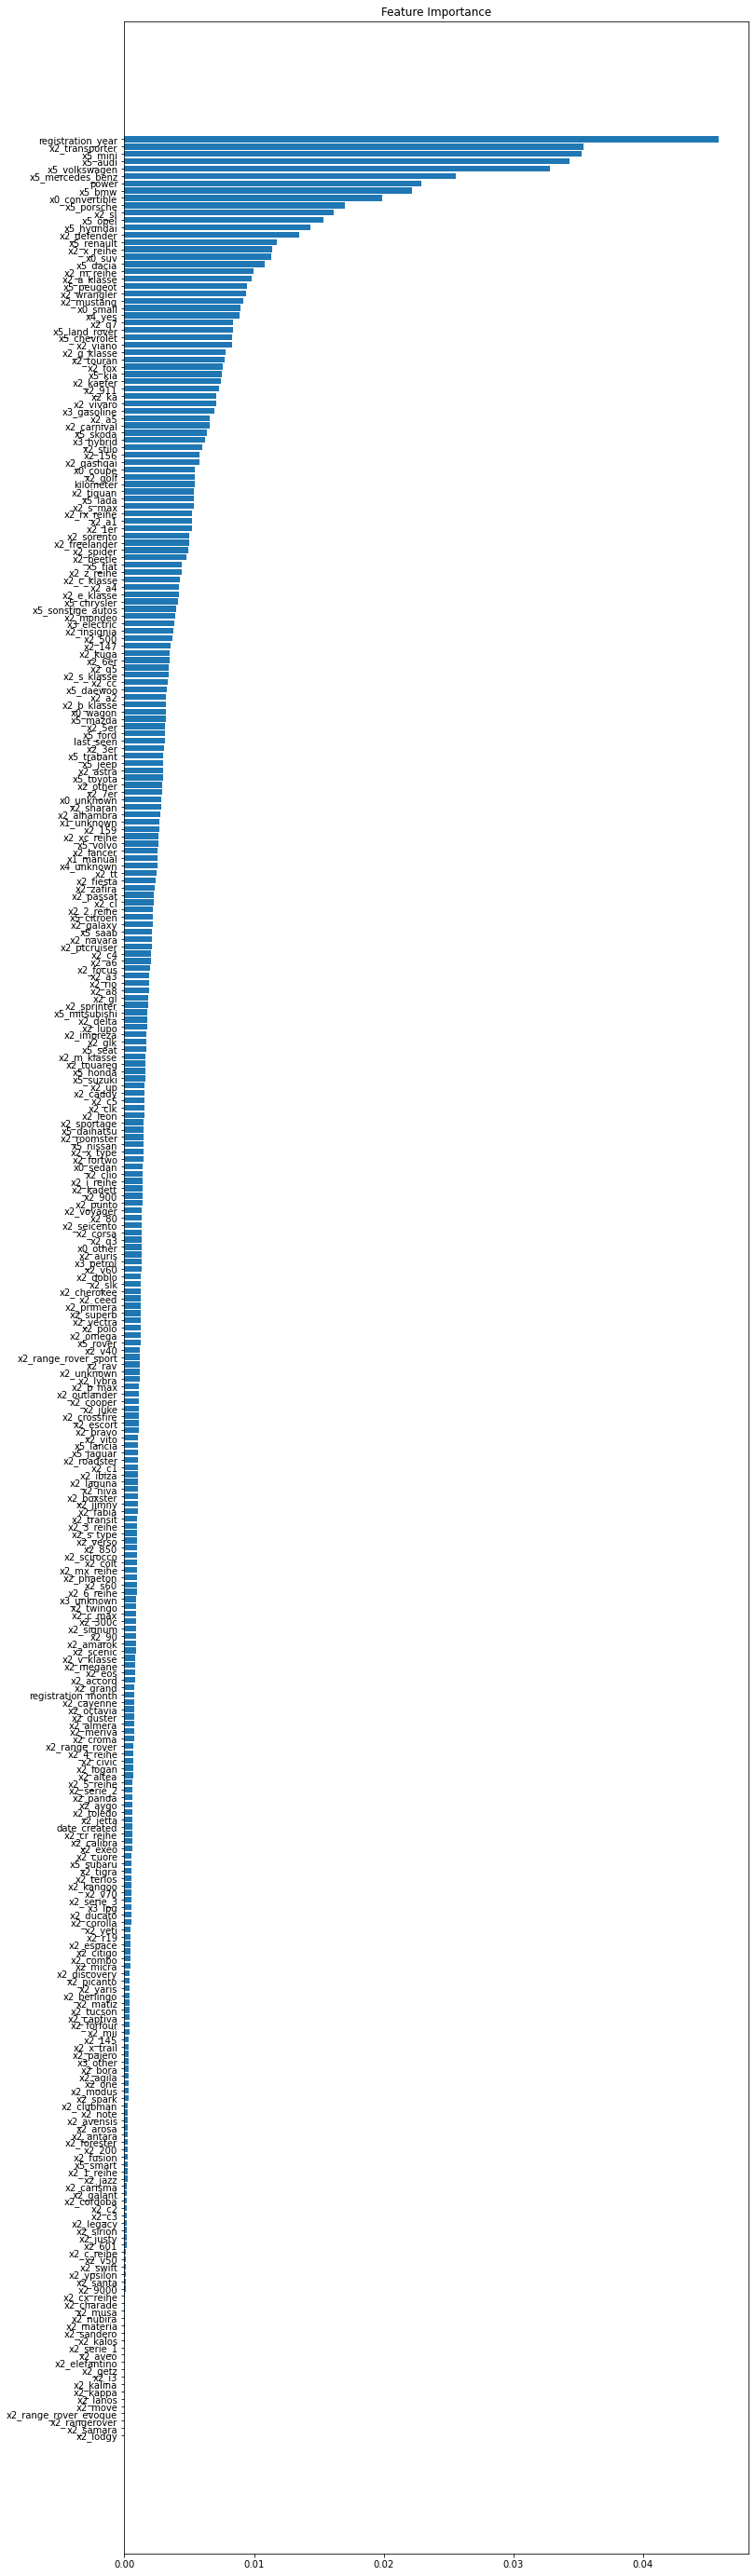

In [36]:
%%time
model = XGBRegressor(random_state=42)
parameters = {'n_estimators': [300], 'learning_rate': [.1, .5]}
best_xgb = teach_model(model, parameters, train_features, train_target,time_list)

1630.7690475975978
{'learning_rate': 0.5, 'n_estimators': 300}
CPU times: total: 13.9 s
Wall time: 29.8 s


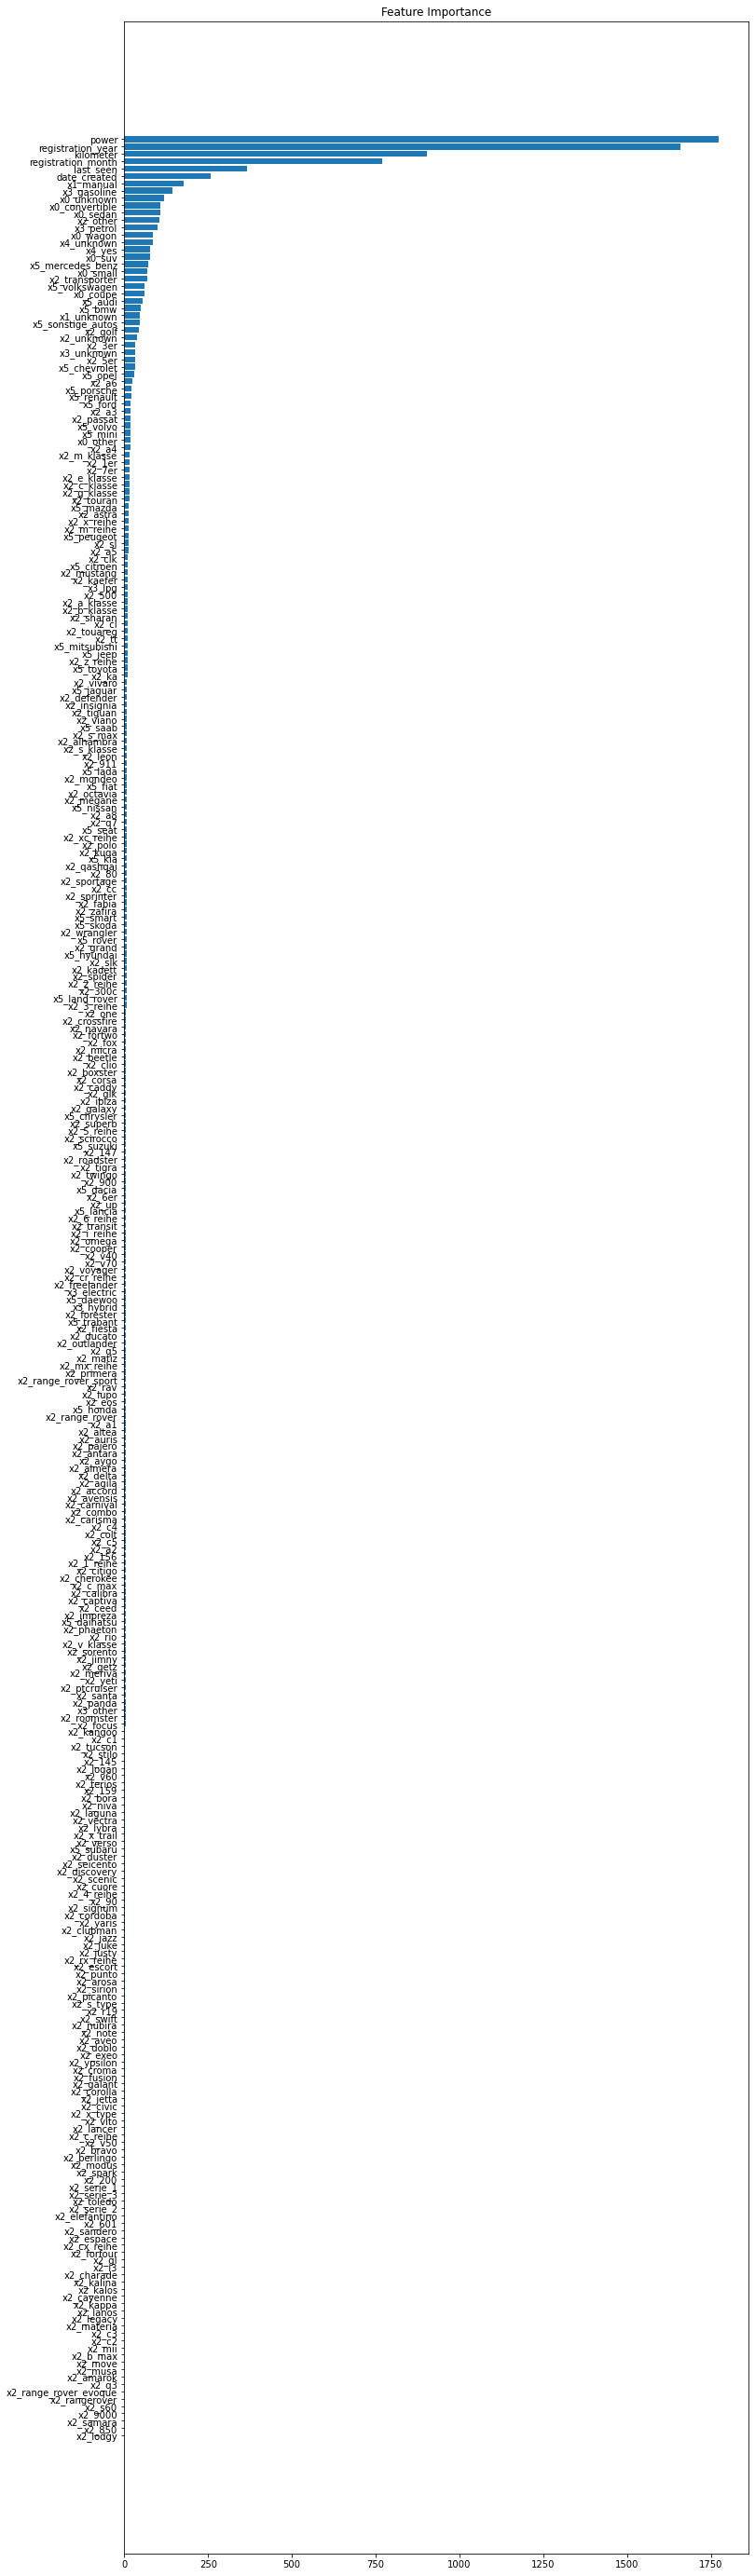

In [37]:
%%time
model = LGBMRegressor(random_state=42)
parameters = {'learning_rate': [.1, .5], 'n_estimators': [200, 300]}
best_lgbm = teach_model(model, parameters, train_features, train_target,time_list)

In [38]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features_lr = scaler.transform(train_features)
test_features_lr = scaler.transform(test_features)

In [39]:
%%time
model = LinearRegression()
parameters = {}
best_lr = teach_model(model, parameters, train_features_lr, train_target,time_list)

2611.7659238523506
{}
CPU times: total: 12.9 s
Wall time: 13.6 s


In [40]:
pd.DataFrame(columns=['mean_learning_time (sec)', 'mean_fit_time (sec)','RMSE'],
             index=['DecisionTree', 'CatBoost', 'XGBoost', 'LGBM', 'LinearRegression'],
             data=time_list)

,mean_learning_time (sec),mean_fit_time (sec),RMSE
DecisionTree,8.312959,0.977289,2348.016873
CatBoost,12.740075,0.062414,1600.828341
XGBoost,473.194270,1.002954,1630.427081
LGBM,16.397260,2.147541,1630.769048
LinearRegression,9.821678,0.038061,2611.765924


Среди всех моделей наилучшую метрику имеет `CatBoostRegressor`, но его обучение заняло в среднем 12.
В то же время модель `DecisionTree` показала метрику сильно хуже , чем `CatBoostRegressor`, но справилась с этим за 8 секунд.
Модель `CatBoostRegressor` также имеет наилучший показатель времени предсказания среди остальных моделей

Так как заказчику важно и время обучения модели, время предсказания модели, и качество предсказания, то можно выбрать одну из двух моделей основываясь на превалирующем факторе заказчика.

Для продолжения получения результата остановимся на том, что `CatBoost` "выиграл" в двух из трёх требований среди остальных моделей\
Отсюда наилучшей моделью выбираем - `CatBoostRegressor`

In [41]:
prediction = best_cb.predict(test_features)

Посчитаем `RMSE` модели на тестовой выборке:

In [42]:
mean_squared_error(test_target, prediction)**.5

1588.1545466977434

Получаем, что наилучшая модель `CatBoostRegressor` ошибается в среднем на +- 1588 евро.

# Проверка модели на адекватность

In [43]:
dummy = DummyRegressor()
dummy.fit(train_features, train_target)
dummy_predict = dummy.predict(test_features)

mean_squared_error(test_target, dummy_predict)**.5

4525.640795884502

Метрика модели `CatBoostRegressor` почти в 3 раза меньше метрики константной модели, что показывает адекватность обученной модели `CatBoostRegressor`

# Вывод

Опираясь на проведённый анализ можно подытожить:
 - [x] Потенциальные требования заказчика удовлетворены ( Скорость обучения модели, точность предсказания)
 - [x] Модель проходит проверку на адекватность, что говорит о необходимости использования ML в данной задаче
 - Наилучшая модель по качеству предсказания - `CatBoostRegressor`
 - Наилучшая модель по скорости предсказания(учитывая адекватное качество) - `LGBMRegressor` 